In [124]:
import requests
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from InstructorEmbedding import INSTRUCTOR
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [128]:
dataFrame = pd.read_csv('focus_dataset.csv')
sentences_1 = dataFrame['Sentece1'].tolist()
sentences_2 = dataFrame['Sentece2'].tolist()
scores = dataFrame['Score'].tolist()

In [130]:
# Model: sentence-transformers/all-mpnet-base-v2 (https://huggingface.co/sentence-transformers/all-mpnet-base-v2)
model_all_mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
scores_all_mpnet_base_v2 = []

In [131]:
for i in range (len(sentences_1)):
    sentences = [sentences_1[i], sentences_2[i]]        
    paraphrases = util.paraphrase_mining(model_all_mpnet, sentences)
    for paraphrase in paraphrases:
        score, i, j = paraphrase
        scores_all_mpnet_base_v2.append(score)

In [ ]:
model_sn_xlm = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')
scores_sn_xlm = []

In [ ]:
for i in range (len(sentences_1)):
    sentences = [sentences_1[i], sentences_2[i]]        
    paraphrases = util.paraphrase_mining(model_sn_xlm, sentences)
    for paraphrase in paraphrases:
        score, i, j = paraphrase
        scores_sn_xlm.append(score)

In [132]:
eval = dataFrame['Score']
eval = pd.concat([eval, pd.DataFrame({'mpnetScore': scores_all_mpnet_base_v2, 'xlnScore': scores_sn_xlm})], axis=1)
eval['Score'] = eval['Score'] / 5
eval

,Score,mpnetScore,xlnScore
0,0.50,0.751502,0.835926
1,0.72,0.802421,0.794322
2,1.00,0.970881,0.937484
3,0.84,0.899563,0.875401
4,0.30,0.396793,0.365940
...,...,...,...
837,0.80,0.966470,0.962412
838,0.80,0.778657,0.734625
839,0.55,0.775953,0.667699
840,0.45,0.797687,0.829092


 # Estadisticas

In [159]:
eval['diff_mpnet'] = eval['mpnetScore'] - eval['Score']
eval['diff_xln'] = eval['xlnScore'] - eval['Score']

In [160]:
eval[['diff_mpnet', 'diff_xln']].describe()

,diff_mpnet,diff_xln
count,842.000000,842.000000
mean,0.074870,0.011392
std,0.128440,0.173933
min,-0.279184,-0.679057
25%,-0.014192,-0.084244
50%,0.069219,0.011058
75%,0.156415,0.117324
max,0.550217,0.494034


## Distibucion del error

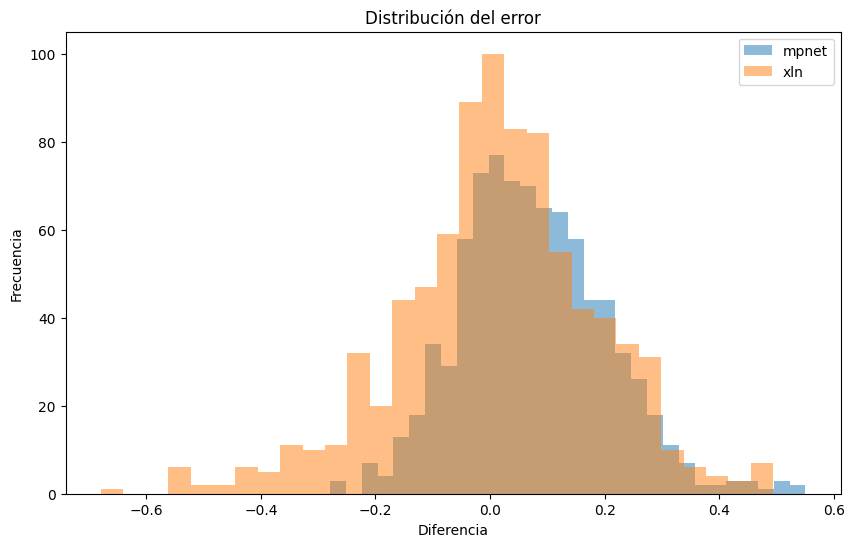

In [185]:
plt.figure(figsize=(10,6))

plt.hist(eval['diff_mpnet'], bins=30, alpha=0.5, label='mpnet')
plt.hist(eval['diff_xln'], bins=30, alpha=0.5, label='xln')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Distribución del error')
plt.show()

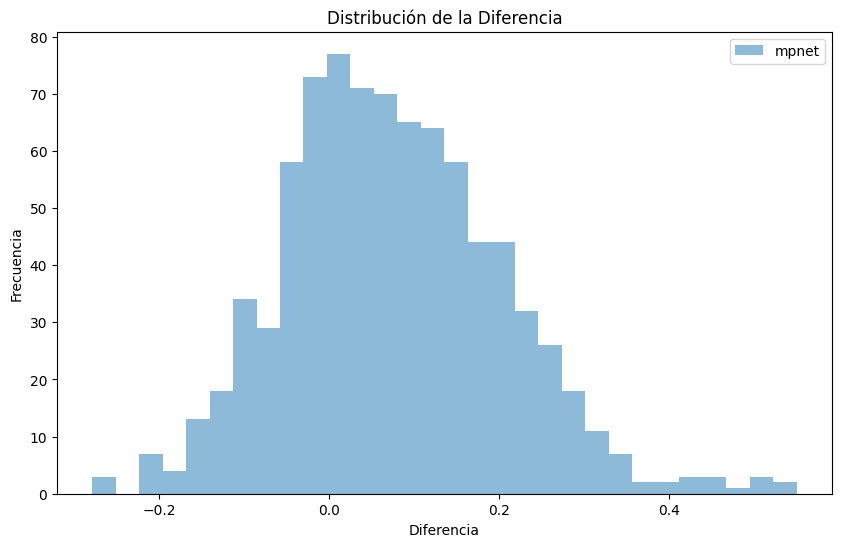

In [162]:
plt.figure(figsize=(10,6))

plt.hist(eval['diff_mpnet'], bins=30, alpha=0.5, label='mpnet')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Diferencia')
plt.show()

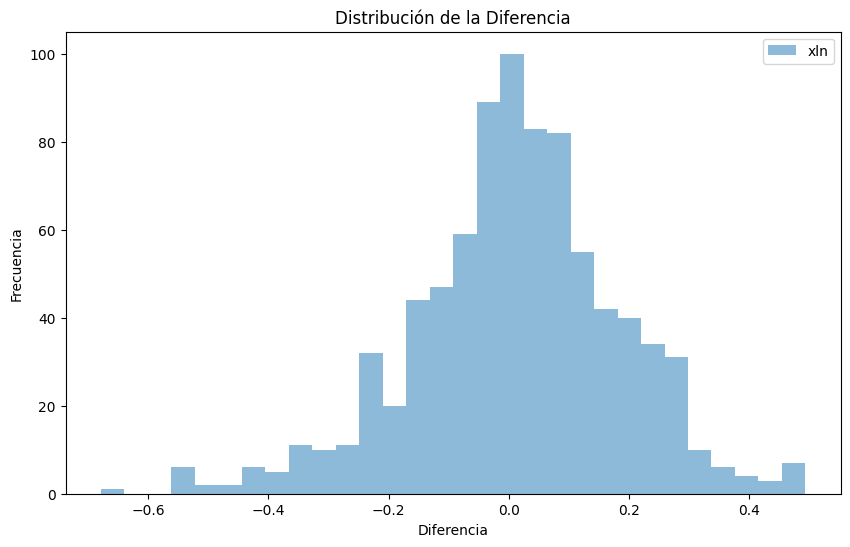

In [163]:
plt.figure(figsize=(10,6))

plt.hist(eval['diff_xln'], bins=30, alpha=0.5, label='xln')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Diferencia')
plt.show()

## Matriz de confusion

Considera que una prediccion <.5 es negativa y >= .5 es positiva.

In [164]:
eval['Score_bin'] = (eval['Score'] >= 0.5).astype(int)
eval['mpnetScore_bin'] = (eval['mpnetScore'] >= 0.5).astype(int)
eval['xlnScore_bin'] = (eval['xlnScore'] >= 0.5).astype(int)

conf_mat_mpnet = confusion_matrix(eval['Score_bin'], eval['mpnetScore_bin'])
conf_mat_xln = confusion_matrix(eval['Score_bin'], eval['xlnScore_bin'])

print("Matriz de confusión mpnetScore:\n", conf_mat_mpnet)
print("\nMatriz de confusión xlnScore:\n", conf_mat_xln)

Matriz de confusión mpnetScore:
 [[263  89]
 [ 15 475]]

Matriz de confusión xlnScore:
 [[278  74]
 [ 62 428]]


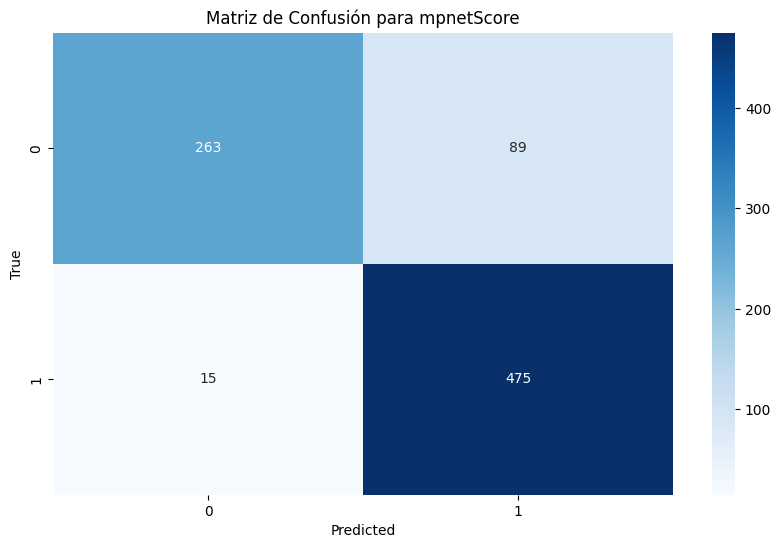

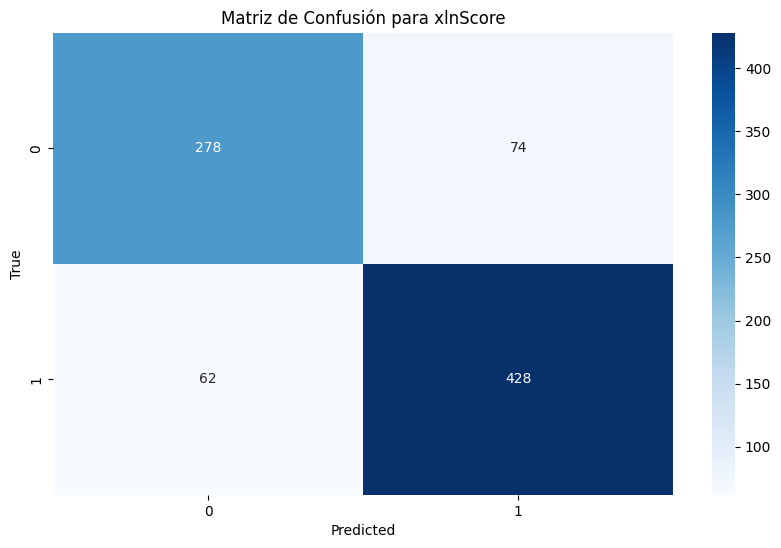

In [165]:
conf_mat_mpnet = confusion_matrix(eval['Score_bin'], eval['mpnetScore_bin'])
conf_mat_xln = confusion_matrix(eval['Score_bin'], eval['xlnScore_bin'])

plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_mpnet, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión para mpnetScore')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_xln, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión para xlnScore')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Cuartiles
    Hay dos graficas para cada uno, solo por razones esteticas para ver despues cual usamos.
### Predicciones

In [166]:
eval[['mpnetScore', 'xlnScore']].describe()

,mpnetScore,xlnScore
count,842.000000,842.000000
mean,0.594739,0.531261
std,0.279468,0.305573
min,-0.113272,-0.192151
25%,0.394887,0.269244
50%,0.673525,0.599022
75%,0.815622,0.786734
max,0.995219,0.997219


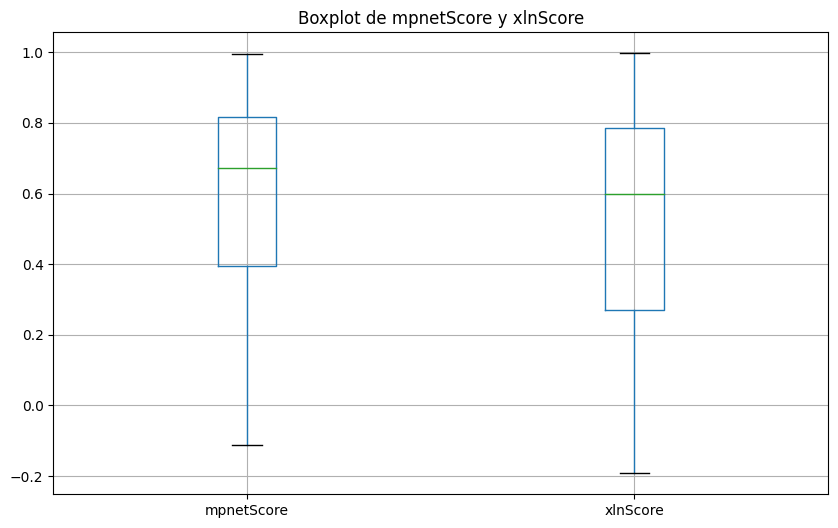

In [167]:
plt.figure(figsize=(10,6))
eval[['mpnetScore', 'xlnScore']].boxplot()
plt.title('Boxplot de mpnetScore y xlnScore')
plt.show()


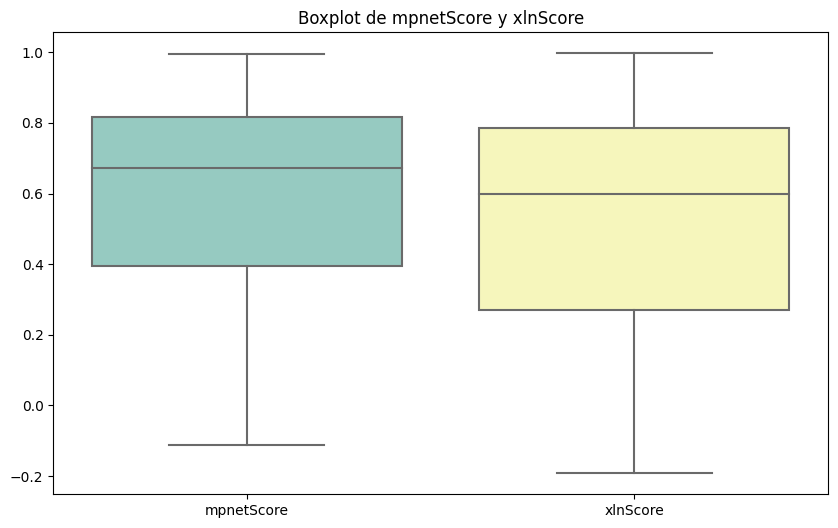

In [168]:
plt.figure(figsize=(10,6))
sns.boxplot(data=eval[['mpnetScore', 'xlnScore']], palette='Set3')
plt.title('Boxplot de mpnetScore y xlnScore')
plt.show()

### Errores

In [169]:
eval[['diff_mpnet', 'diff_xln']].describe()

,diff_mpnet,diff_xln
count,842.000000,842.000000
mean,0.074870,0.011392
std,0.128440,0.173933
min,-0.279184,-0.679057
25%,-0.014192,-0.084244
50%,0.069219,0.011058
75%,0.156415,0.117324
max,0.550217,0.494034


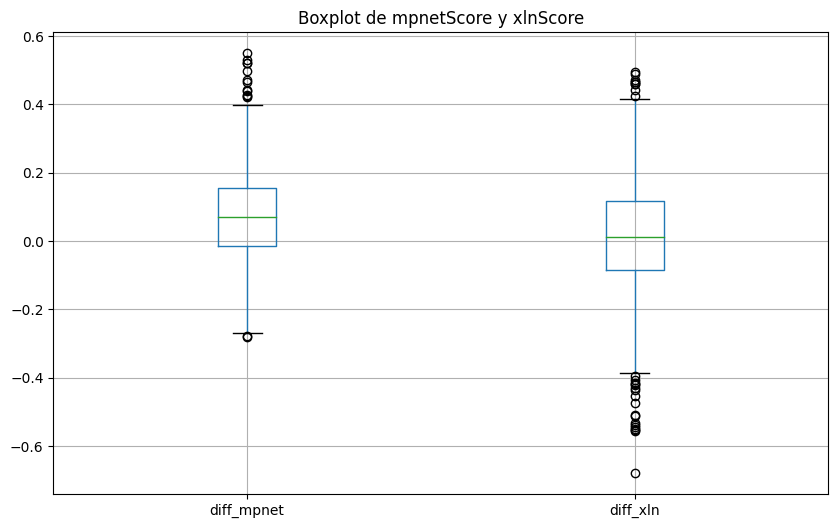

In [170]:
plt.figure(figsize=(10,6))
eval[['diff_mpnet', 'diff_xln']].boxplot()
plt.title('Boxplot de mpnetScore y xlnScore')
plt.show()

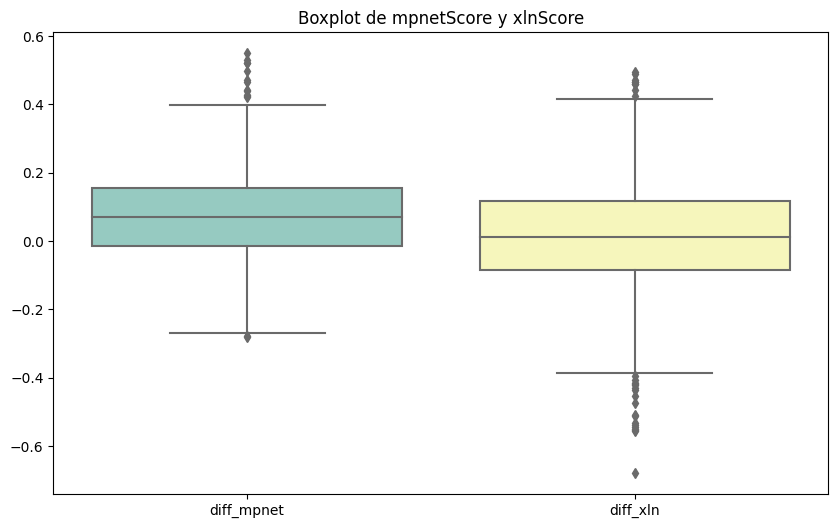

In [171]:
plt.figure(figsize=(10,6))
sns.boxplot(data=eval[['diff_mpnet', 'diff_xln']], palette='Set3')
plt.title('Boxplot de mpnetScore y xlnScore')
plt.show()

## AUC-ROC

In [172]:
auc_mpnet = roc_auc_score(eval['Score_bin'], eval['mpnetScore_bin'])
auc_xln = roc_auc_score(eval['Score_bin'], eval['xlnScore_bin'])

print("AUC-ROC  mpnetScore:", auc_mpnet)
print("AUC-ROC  xlnScore:", auc_xln)

AUC-ROC  mpnetScore: 0.8582734230055657
AUC-ROC  xlnScore: 0.8316210575139147


In [173]:
fpr_mpnet, tpr_mpnet, _ = roc_curve(eval['Score_bin'], eval['mpnetScore_bin'])
fpr_xln, tpr_xln, _ = roc_curve(eval['Score_bin'], eval['xlnScore_bin'])

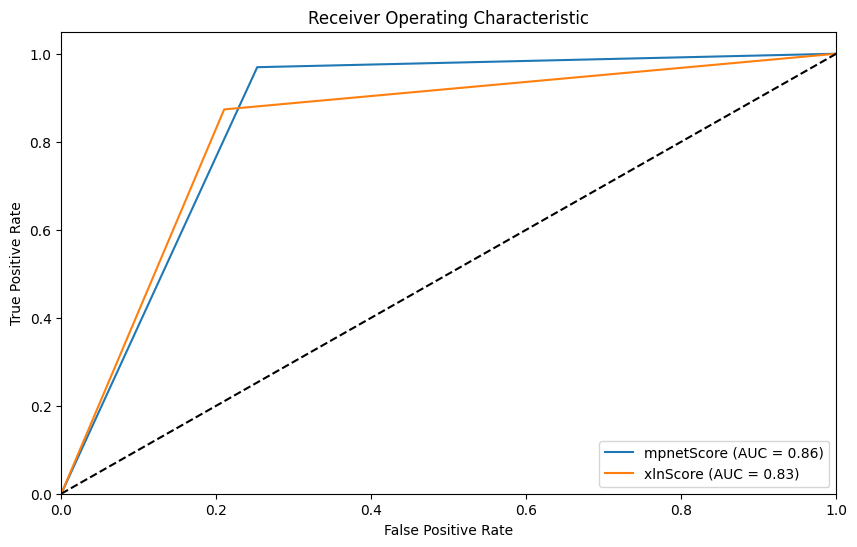

In [174]:
plt.figure(figsize=(10,6))
plt.plot(fpr_mpnet, tpr_mpnet, label='mpnetScore (AUC = %0.2f)' % auc_mpnet)
plt.plot(fpr_xln, tpr_xln, label='xlnScore (AUC = %0.2f)' % auc_xln)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

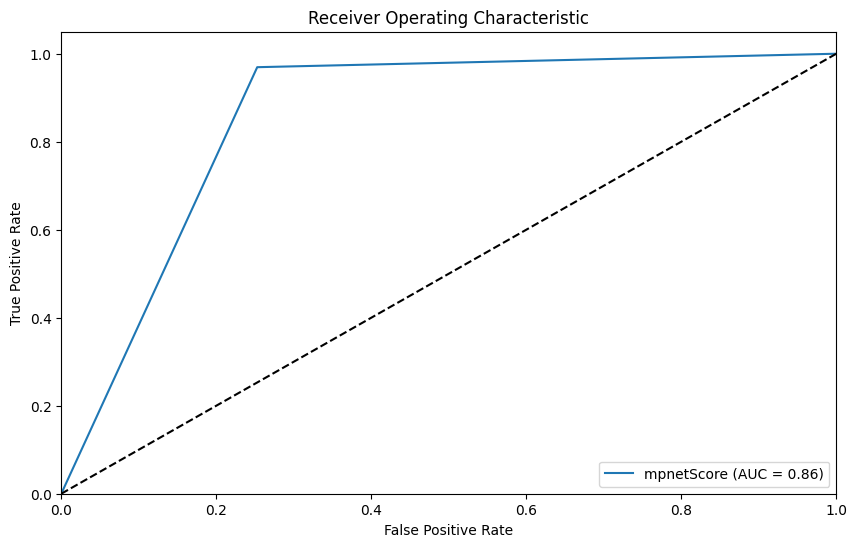

In [175]:
plt.figure(figsize=(10,6))
plt.plot(fpr_mpnet, tpr_mpnet, label='mpnetScore (AUC = %0.2f)' % auc_mpnet)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

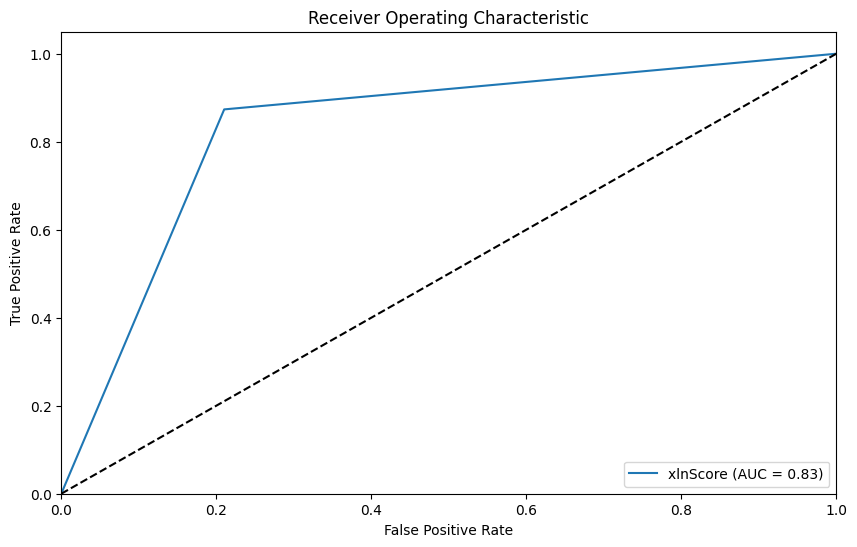

In [176]:
plt.figure(figsize=(10,6))
plt.plot(fpr_xln, tpr_xln, label='xlnScore (AUC = %0.2f)' % auc_xln)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Pearson

In [177]:
pearson_corr_mpnet = eval['Score'].corr(eval['mpnetScore'])
pearson_corr_xln = eval['Score'].corr(eval['xlnScore'])

print("Coeficiente de correlación de Pearson mpnetScore:", pearson_corr_mpnet)
print("Coeficiente de correlación de Pearson xlnScore:", pearson_corr_xln)

Coeficiente de correlación de Pearson mpnetScore: 0.899841588647292
Coeficiente de correlación de Pearson xlnScore: 0.8314695225163526


# Metricas de regresion
    MAE, MSE, RMSE, coeficiente de determinacion R²

In [178]:
# MAE
mae_mpnet = mean_absolute_error(eval['Score'], eval['mpnetScore'])
mae_xln = mean_absolute_error(eval['Score'], eval['xlnScore'])

# MSE
mse_mpnet = mean_squared_error(eval['Score'], eval['mpnetScore'])
mse_xln = mean_squared_error(eval['Score'], eval['xlnScore'])

# RMSE
rmse_mpnet = sqrt(mse_mpnet)
rmse_xln = sqrt(mse_xln)

# Coeficiente de Determinación R²
r2_mpnet = r2_score(eval['Score'], eval['mpnetScore'])
r2_xln = r2_score(eval['Score'], eval['xlnScore'])


In [179]:
print("mpnetScore:")
print("MAE:", mae_mpnet)
print("MSE:", mse_mpnet)
print("RMSE:", rmse_mpnet)
print("R²:", r2_mpnet)

mpnetScore:
MAE: 0.11466200284768613
MSE: 0.022082637102767883
RMSE: 0.14860227825564412
R²: 0.740545919185878


In [180]:
print("xlnScore:")
print("MAE:", mae_xln)
print("MSE:", mse_xln)
print("RMSE:", rmse_xln)
print("R²:", r2_xln)

xlnScore:
MAE: 0.13241562085544553
MSE: 0.030346506136789412
RMSE: 0.17420248602356228
R²: 0.6434517843589466


## Precision-recall

In [181]:
precision_mpnet, recall_mpnet, _ = precision_recall_curve(eval['Score_bin'], eval['mpnetScore_bin'])
precision_xln, recall_xln, _ = precision_recall_curve(eval['Score_bin'], eval['xlnScore_bin'])

auc_pr_mpnet = auc(recall_mpnet, precision_mpnet)
auc_pr_xln = auc(recall_xln, precision_xln)

print("AUC para la curva Precision-Recall mpnetScore:", auc_pr_mpnet)
print("AUC para la curva Precision-Recall xlnScore:", auc_pr_xln)


AUC para la curva Precision-Recall mpnetScore: 0.9147005317515897
AUC para la curva Precision-Recall xlnScore: 0.8998466167324498


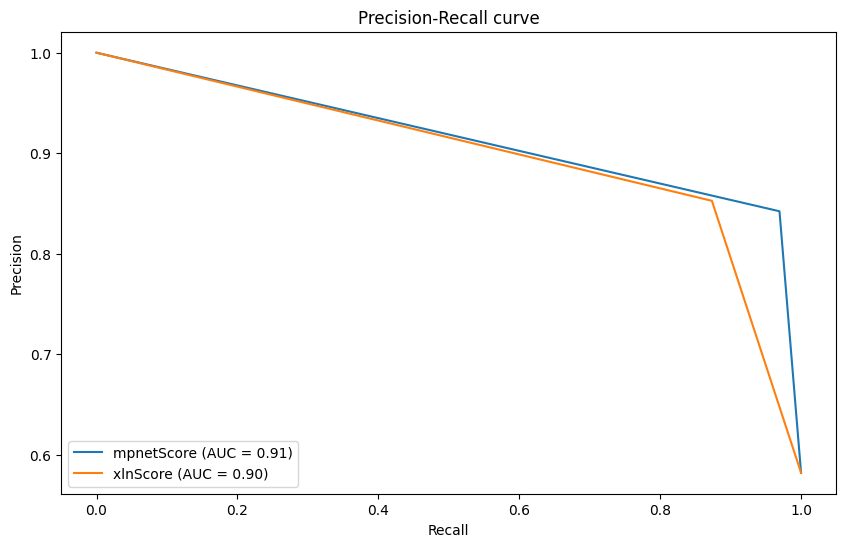

In [182]:
plt.figure(figsize=(10,6))
plt.plot(recall_mpnet, precision_mpnet, label='mpnetScore (AUC = %0.2f)' % auc_pr_mpnet)
plt.plot(recall_xln, precision_xln, label='xlnScore (AUC = %0.2f)' % auc_pr_xln)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

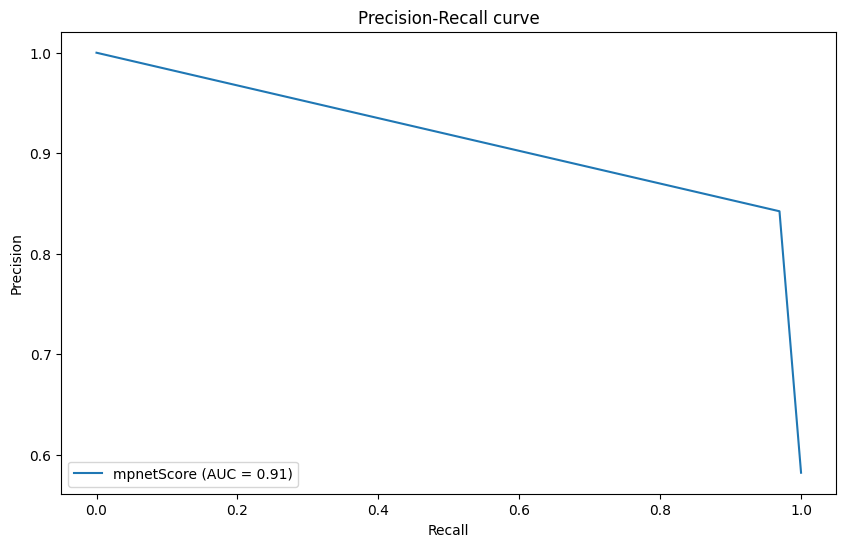

In [183]:
plt.figure(figsize=(10,6))
plt.plot(recall_mpnet, precision_mpnet, label='mpnetScore (AUC = %0.2f)' % auc_pr_mpnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

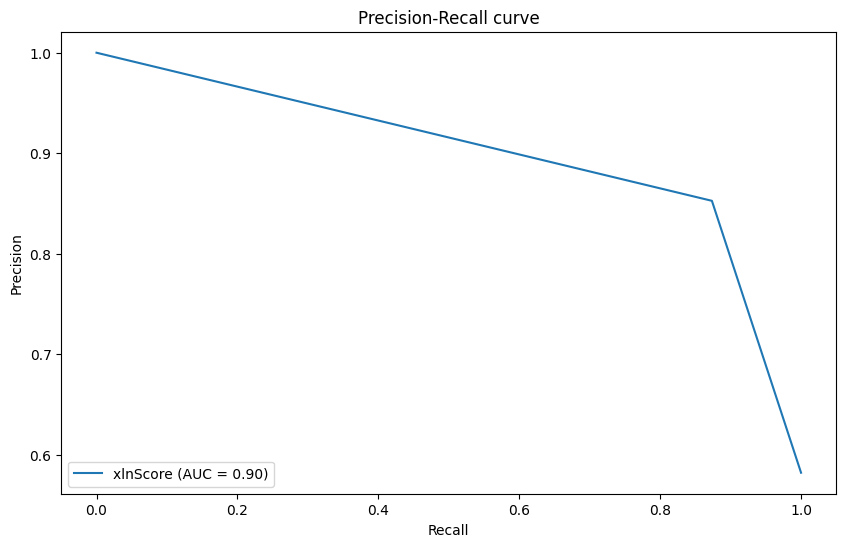

In [184]:
plt.figure(figsize=(10,6))
plt.plot(recall_xln, precision_xln, label='xlnScore (AUC = %0.2f)' % auc_pr_xln)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()